In [1]:
import sys
sys.version


'2.7.12 (default, Dec  4 2017, 14:50:18) \n[GCC 5.4.0 20160609]'

In [8]:
import caffe

(360, 480, 3)


(-0.5, 479.5, 359.5, -0.5)

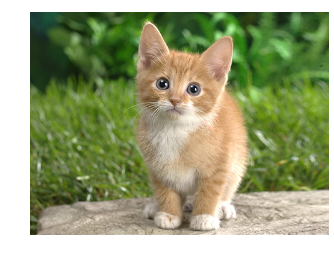

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import caffe
caffe_root='/home/Shengping/caffe/'
import os,sys
os.chdir(caffe_root)
sys.path.insert(0,caffe_root+'python')
im = caffe.io.load_image('examples/images/cat.jpg')
print im.shape
plt.imshow(im)
plt.axis('off')

%matplotlib具体作用是当你调用matplotlib.pyplot的绘图函数plot()进行绘图的时候，或者生成一个figure画布的时候，可以直接在你的python console里面生成图像。

In [3]:
! cat examples/net_surgery/conv.prototxt

# Simple single-layer network to showcase editing model parameters.
name: "convolution"
layer {
  name: "data"
  type: "Input"
  top: "data"
  input_param { shape: { dim: 1 dim: 3 dim: 100 dim: 100 } }
}
layer {
  name: "conv"
  type: "Convolution"
  bottom: "data"
  top: "conv"
  convolution_param {
    num_output: 16
    kernel_size: 5
    stride: 1
    weight_filler {
      type: "gaussian"
      std: 0.01
    }
    bias_filler {
      type: "constant"
      value: 0
    }
  }
}


data-blobs: (1, 3, 360, 480)


(-0.5, 479.5, 359.5, -0.5)

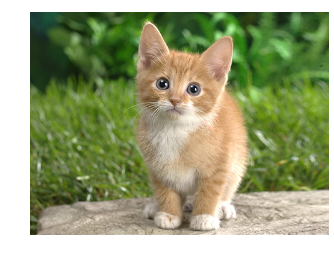

In [4]:
net = caffe.Net('examples/net_surgery/conv.prototxt', caffe.TEST)
im_input=im[np.newaxis,:,:,:].transpose(0,3,1,2)
print "data-blobs:",im_input.shape
net.blobs['data'].reshape(*im_input.shape)
net.blobs['data'].data[...] = im_input
plt.imshow(net.blobs['data'].data[0].transpose(1,2,0))
plt.axis('off')

# 注释

## numpy中包含的newaxis可以给原数组增加一个维度

```
x = np.random.randint(1, 8, size=5)

x
Out[48]: array([4, 6, 6, 6, 5])

x1 = x[np.newaxis, :]

x1
Out[50]: array([[4, 6, 6, 6, 5]])
```
## transpose
比如说三维的数组，那就对维度进行编号，也就是0,1,2。这样说可能比较抽象。这里的0,1,2可以理解为对shape返回元组的索引。
比如：
```
In [59]: arr1 = np.arange(12).reshape(2,2,3)

In [60]: arr1
Out[60]:
array([[[ 0,  1,  2],
        [ 3,  4,  5]],

       [[ 6,  7,  8],
        [ 9, 10, 11]]])

In [61]: arr1.shape #看形状
Out[61]: (2, 2, 3) #说明这是一个2*2*3的数组（矩阵），返回的是一个元组，可以对元组进行索引，也就是0,1,2
```
形状	索引
2	0
2	1
3	2
所以说，transpose参数的真正意义在于这个shape元组的索引。

那么它的转置就应该是

```
In [62]: arr1.transpose((1,0,2))
Out[62]:
array([[[ 0,  1,  2],
        [ 6,  7,  8]],

       [[ 3,  4,  5],
        [ 9, 10, 11]]])
```
比如，数值6开始的索引是[1,0,0]，变换后变成了[0,1,0]。
这也说明了，transpose依赖于shape。

## python形参

它以一个*加上形参名的方式来表示这个函数的实参个数不定，可能为0个也可能为n个。注意一点是，不管有多少个，在函数内部都被存放在以形参名为标识符的tuple中。

>>> def a(*x):
```
if len(x)==0:
   print 'None'
else:
   print x
```

>>> a(1)
```
(1,)        #存放在元组中
```
>>> a()
```
None
```
>>> a(1,2,3)
```
(1, 2, 3)
```

>>> a(m=1,y=2,z=3)
```
Traceback (most recent call last):
File "<pyshell#16>", line 1, in -toplevel-
    a(m=1,y=2,z=3)
TypeError: a() got an unexpected keyword argument 'm'
```



In [5]:
plt.rcParams['image.cmap'] = 'gray'

def show_data(data,head,padsize=1, padval=0):
    data -= data.min()
    data /= data.max()
    
    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = ((0, n ** 2 - data.shape[0]), (0, padsize), (0, padsize)) + ((0, 0),) * (data.ndim - 3)
    data = np.pad(data, padding, mode='constant', constant_values=(padval, padval))
    
    # tile the filters into an image
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    plt.figure()
    plt.title(head)
    plt.imshow(data)
    plt.axis('off')

data-blobs: (1, 3, 360, 480)


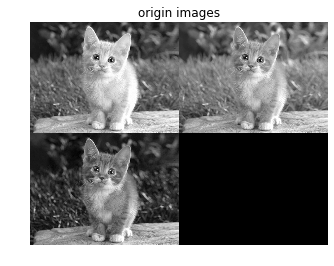

In [6]:
print "data-blobs:",net.blobs['data'].data.shape
show_data(net.blobs['data'].data[0],'origin images')

data-blobs: (1, 3, 360, 480)
conv-blobs: (1, 16, 356, 476)
weight-blobs: (16, 3, 5, 5)


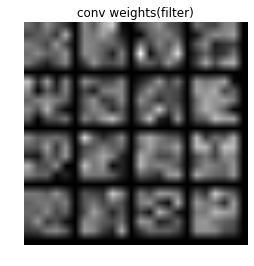

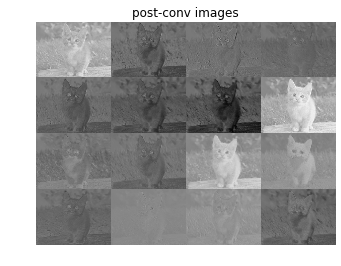

In [11]:
net.forward()
print "data-blobs:",net.blobs['data'].data.shape
print "conv-blobs:",net.blobs['conv'].data.shape
print "weight-blobs:",net.params['conv'][0].data.shape
show_data(net.params['conv'][0].data[:,0],'conv weights(filter)')
show_data(net.blobs['conv'].data[0],'post-conv images')

# Caffe-Python接口常用API参考

## Packages导入
```
import caffe
from caffe import layers as L
from caffe import params as P
```
## Layers定义

### Data层定义

lmdb/leveldb Data层定义
```
L.Data( 
        source=lmdb,
        backend=P.Data.LMDB,
        batch_size=batch_size, ntop=2,
        transform_param=dict(
                              crop_size=227,
                              mean_value=[104, 117, 123],
                              mirror=True
                              )
        )
```
### HDF5 Data层定义
```
L.HDF5Data(
            hdf5_data_param={
                            'source': './training_data_paths.txt',  
                            'batch_size': 64
                            },
            include={
                    'phase': caffe.TRAIN
                    }
            )
```
### ImageData Data层定义

适用于txt文件一行记录一张图片的数据源
```
L.ImageData(
                source=list_path,
                batch_size=batch_size,
                new_width=48,
                new_height=48,
                ntop=2,
                ransform_param=dict(crop_size=40,mirror=True)
                )
```                
### Convloution层定义
```
L.Convolution(  
                bottom, 
                kernel_size=ks, 
                stride=stride,
                num_output=nout, 
                pad=pad, 
                group=group
                )
```                
### LRN层定义
```
L.LRN(
        bottom, 
        local_size=5, 
        alpha=1e-4, 
        beta=0.75
        )
```        
### Activation层定义

ReLU层定义
```
L.ReLU(
        bottom, 
        in_place=True
        )
```        
### Pooling层定义
```
L.Pooling(
            bottom,
            pool=P.Pooling.MAX, 
            kernel_size=ks, 
            stride=stride
            )
```            
### FullConnect层定义
```
L.InnerProduct(
                bottom, 
                num_output=nout
                )
```                
### Dropout层定义
```
L.Dropout(
            bottom, 
            in_place=True
            )
```           
### Loss层定义
```
L.SoftmaxWithLoss(
                    bottom, 
                    label
                    )
```                    
### Accuracy层定义
```
L.Accuracy(
            bottom,
            label
            )
```            
### 转换为proto文本
```
caffe.to_proto(
                loss, 
                acc     #训练阶段可以删去Accuracy层
                )
```               
### Solver定义
```
from caffe.proto import caffe_pb2

s = caffe_pb2.SolverParameter()

path='/home/xxx/data/'
solver_file=path+'solver.prototxt'     #solver文件保存位置

s.train_net = path+'train.prototxt'     # 训练配置文件
s.test_net.append(path+'val.prototxt')  # 测试配置文件
s.test_interval = 782                   # 测试间隔
s.test_iter.append(313)                 # 测试迭代次数
s.max_iter = 78200                      # 最大迭代次数

s.base_lr = 0.001                       # 基础学习率
s.momentum = 0.9                        # momentum系数
s.weight_decay = 5e-4                   # 权值衰减系数
s.lr_policy = 'step'                    # 学习率衰减方法
s.stepsize=26067                        # 此值仅对step方法有效
s.gamma = 0.1                           # 学习率衰减指数
s.display = 782                         # 屏幕日志显示间隔
s.snapshot = 7820
s.snapshot_prefix = 'shapshot'
s.type = “SGD”                          # 优化算法
s.solver_mode = caffe_pb2.SolverParameter.GPU

with open(solver_file, 'w') as f:
    f.write(str(s))
```
## Model训练

### 训练设置
```
# 使用GPU
caffe.set_device(gpu_id) # 若不设置,默认为0
caffe.set_mode_gpu()
# 使用CPU
caffe.set_mode_cpu()
```
### 加载Solver，有两种常用方法
```
# 1. 无论模型中Slover类型是什么统一设置为SGD
solver = caffe.SGDSolver('/home/xxx/data/solver.prototxt') 
# 2. 根据solver的prototxt中solver_type读取，默认为SGD
solver = caffe.get_solver('/home/xxx/data/solver.prototxt')
```
### 训练模型
```
# 1.1 前向传播
solver.net.forward()  # train net
solver.test_nets[0].forward()  # test net (there can be more than one)
# 1.2 反向传播,计算梯度
solver.net.backward()
# 2. 进行一次前向传播一次反向传播并根据梯度更新参数
solver.step(1)
# 3. 根据solver文件中设置进行完整model训练
solver.solve()
```

如果想在训练过程中保存模型参数，调用

solver.net.save('mymodel.caffemodel')

## 分类图片

### 加载Model数据
```
net = caffe.Net(
        deploy_prototxt_path,   # 用于分类的网络定义文件路径
        caffe_model_path,       # 训练好模型路径
        caffe.TEST              # 设置为测试阶段
        )
```
### 中值文件转换
```
#　编写一个函数，将二进制的均值转换为python的均值
def convert_mean(binMean,npyMean):
    blob = caffe.proto.caffe_pb2.BlobProto()
    bin_mean = open(binMean, 'rb' ).read()
    blob.ParseFromString(bin_mean)
    arr = np.array( caffe.io.blobproto_to_array(blob) )
    npy_mean = arr[0]
    np.save(npyMean, npy_mean )
```
### 调用函数转换均值
```
binMean='examples/cifar10/mean.binaryproto'
npyMean='examples/cifar10/mean.npy'
convert_mean(binMean,npyMean)
```
# 图片预处理

```
# 设定图片的shape格式为网络data层格式
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})
# 改变维度的顺序，由原始图片维度(width, height, channel)变为(channel, width, height)
transformer.set_transpose('data', (2,0,1)) 
# 减去均值,注意要先将binaryproto格式均值文件转换为npy格式[此步根据训练model时设置可选]
transformer.set_mean('data', np.load(mean_file_path).mean(1).mean(1))
# 缩放到[0，255]之间
transformer.set_raw_scale('data', 255)
# 交换通道，将图片由RGB变为BGR
transformer.set_channel_swap('data', (2,1,0))

# 加载图片
im=caffe.io.load_image(img)

# 执行上面设置的图片预处理操作，并将图片载入到blob中
net.blobs['data'].data[...] = transformer.preprocess('data',im)
```
## 执行测试
```
#执行测试
out = net.forward()

labels = np.loadtxt(labels_filename, str, delimiter='\t')   #读取类别名称文件
prob= net.blobs['Softmax1'].data[0].flatten() #取出最后一层（Softmax）属于某个类别的概率值，并打印
print prob
order=prob.argsort()[0]  #将概率值排序，取出最大值所在的序号 
print 'the class is:',labels[order]   #将该序号转换成对应的类别名称，并打印

# 取出前五个较大值所在的序号
top_inds = prob.argsort()[::-1][:5]
print 'probabilities and labels:' zip(prob[top_inds], labels[top_inds])
各层信息显示

# params显示：layer名，w，b
for layer_name, param in net.params.items():
    print layer_name + '\t' + str(param[0].data.shape), str(param[1].data.shape)

# blob显示：layer名，输出的blob维度
for layer_name, blob in net.blobs.items():
    print layer_name + '\t' + str(blob.data.shape)
```    
    
## 自定义函数:参数/卷积结果可视化

```
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import caffe
%matplotlib inline

plt.rcParams['figure.figsize'] = (8, 8)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

def show_data(data, padsize=1, padval=0):
"""Take an array of shape (n, height, width) or (n, height, width, 3)
       and visualize each (height, width) thing in a grid of size approx. sqrt(n) by sqrt(n)"""
    # data归一化
    data -= data.min()
    data /= data.max()
    
    # 根据data中图片数量data.shape[0]，计算最后输出时每行每列图片数n
    n = int(np.ceil(np.sqrt(data.shape[0])))
    # padding = ((图片个数维度的padding),(图片高的padding), (图片宽的padding), ....)
    padding = ((0, n ** 2 - data.shape[0]), (0, padsize), (0, padsize)) + ((0, 0),) * (data.ndim - 3)
    data = np.pad(data, padding, mode='constant', constant_values=(padval, padval))
    
    # 先将padding后的data分成n*n张图像
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    # 再将（n, W, n, H）变换成(n*w, n*H)
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    plt.figure()
    plt.imshow(data,cmap='gray')
    plt.axis('off')
```

## 示例：显示第一个卷积层的输出数据和权值（filter）

```
print net.blobs['conv1'].data[0].shape
show_data(net.blobs['conv1'].data[0])
print net.params['conv1'][0].data.shape
show_data(net.params['conv1'][0].data.reshape(32*3,5,5))
```

## 自定义：训练过程Loss&Accuracy可视化

```
import matplotlib.pyplot as plt  
import caffe   
caffe.set_device(0)  
caffe.set_mode_gpu()   
# 使用SGDSolver，即随机梯度下降算法  
solver = caffe.SGDSolver('/home/xxx/mnist/solver.prototxt')  
  
# 等价于solver文件中的max_iter，即最大解算次数  
niter = 10000 

# 每隔100次收集一次loss数据  
display= 100  
  
# 每次测试进行100次解算 
test_iter = 100

# 每500次训练进行一次测试
test_interval =500
  
#初始化 
train_loss = zeros(ceil(niter * 1.0 / display))   
test_loss = zeros(ceil(niter * 1.0 / test_interval))  
test_acc = zeros(ceil(niter * 1.0 / test_interval))  
  
# 辅助变量  
_train_loss = 0; _test_loss = 0; _accuracy = 0  
# 进行解算  
for it in range(niter):  
    # 进行一次解算  
    solver.step(1)  
    # 统计train loss  
    _train_loss += solver.net.blobs['SoftmaxWithLoss1'].data  
    if it % display == 0:  
        # 计算平均train loss  
        train_loss[it // display] = _train_loss / display  
        _train_loss = 0  
  
    if it % test_interval == 0:  
        for test_it in range(test_iter):  
            # 进行一次测试  
            solver.test_nets[0].forward()  
            # 计算test loss  
            _test_loss += solver.test_nets[0].blobs['SoftmaxWithLoss1'].data  
            # 计算test accuracy  
            _accuracy += solver.test_nets[0].blobs['Accuracy1'].data  
        # 计算平均test loss  
        test_loss[it / test_interval] = _test_loss / test_iter  
        # 计算平均test accuracy  
        test_acc[it / test_interval] = _accuracy / test_iter  
        _test_loss = 0  
        _accuracy = 0  
  
# 绘制train loss、test loss和accuracy曲线  
print '\nplot the train loss and test accuracy\n'  
_, ax1 = plt.subplots()  
ax2 = ax1.twinx()  
  
# train loss -> 绿色  
ax1.plot(display * arange(len(train_loss)), train_loss, 'g')  
# test loss -> 黄色  
ax1.plot(test_interval * arange(len(test_loss)), test_loss, 'y')  
# test accuracy -> 红色  
ax2.plot(test_interval * arange(len(test_acc)), test_acc, 'r')  
  
ax1.set_xlabel('iteration')  
ax1.set_ylabel('loss')  
ax2.set_ylabel('accuracy')  
plt.show()
```
